# Analyze A/B Test Results 

This notebook is organized into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Now, I will read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

- user_id: unique ID. (Int64 values)
- timestamp: time stamp when the user visited the webpage.
- group: in the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. (`['control', 'treatment']`)
- landing_page: it denotes whether the user visited the old or new webpage. (`['old_page', 'new_page']`)
- converted: it denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product. (`[0, 1]`)


**a.** Reading in the dataset from the `ab_data.csv` file and taking a look at the top few rows:

In [2]:
df = pd.read_csv('../input/ab-data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** The number of rows in the dataset.

In [3]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0]

1965

**f.** Do any of the rows have missing values?

In [7]:
sum([True for idx,row in df.iterrows() if any(row.isnull())])

0

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

In [8]:
# Removing the inaccurate rows, and storing the result in a new dataframe df2
df2 = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) | ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]

In [9]:
# Double Checking all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

**b.** Are there repeated users?

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

**c.** Displaying the rows for the duplicate **user_id**

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Removing **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Removing one of the rows with a duplicate user_id..
df2 = df2.drop_duplicates('user_id')
# Checking again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().sum()

0

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [14]:
p_population = df2.converted.mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2[df2['group'] == 'control'].converted.mean()
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2[df2['group'] == 'treatment'].converted.mean()
p_treatment

0.11880806551510564

In [17]:
# Calculating the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control

**d.** What is the probability that an individual received the new page?

In [18]:
(df.landing_page == 'new_page').mean()

0.5

>The new treatment group users led to a slightly lower conversion rate than the control group users, from which it seems that the conversion rate fot the old page is slightly higher than that of the new page.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, I could run a hypothesis test continuously as long as I observe the events. 

However, then the hard questions would be: 
- Do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, I will consider I need to make the decision just based on all the data provided.  

Null hypothesis: P𝑛𝑒𝑤 <= P𝑜𝑙𝑑

Alternative hypothesis: P𝑛𝑒𝑤 > P𝑜𝑙𝑑 

**Null Hypothesis $H_0$ Testing**

Under the null hypothesis $H_0$, I will assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, I will assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, my assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [19]:
df2_new = df2[df2.landing_page == 'new_page']
n_new = df2_new.shape[0]
n_new

145310

**b.** What is $n_{old}$, the number of individuals in the control group?

In [20]:
df2_old = df2[df2.landing_page == 'old_page']
n_old = df2_old.shape[0]
n_old

145274

**c. Simulating Sample for the `treatment` Group**<br> 
Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [21]:
# Simulating a Sample for the treatment Group
new_page_converted = np.random.choice(df2_new.converted, n_new)

**d. Simulating Sample for the `control` Group** <br>
Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Storing these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [22]:
# Simulating a Sample for the control Group
old_page_converted = np.random.choice(df2_old.converted, n_old)

**e.** Finding the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for my simulated samples. 

In [23]:
new_page_converted.mean() - old_page_converted.mean()

-0.001481773865739694


**f. Sampling distribution** <br>
Re-creating `new_page_converted` and `old_page_converted` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times. 

<br>
Storing all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [24]:
# Sampling distribution 

p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice(df2_new.converted, n_new)
    old_page_converted = np.random.choice(df2_old.converted, n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
p_diffs = np.array(p_diffs)

**g. Histogram**<br> 
Plotting a histogram of the **p_diffs**.

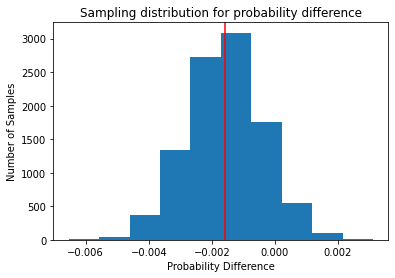

In [25]:
plt.hist(p_diffs)
plt.title('Sampling distribution for probability difference')
plt.xlabel('Probability Difference')
plt.ylabel('Number of Samples')
plt.axvline(obs_diff, c='red');

**h.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [26]:
(p_diffs > obs_diff).mean()
# p-value

0.5025

>The p-value is much larger than the type 1 error rate, which indicates that we should not reject the null hypothesis concluding that there is no difference between the new and old pages.



**I. Using Built-in Methods for Hypothesis Testing**<br>
I could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 


In [27]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2_old.converted.sum()

# number of conversions with the new_page
convert_new = df2_new.converted.sum()

**m.** Now I will use `sm.stats.proportions_ztest()` to compute our test statistic and p-value.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---

In [28]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


* Since our critival value at a level of significance 0.05 equals 1.645 (from the z-table), and this test is a one-sided right-tailed test, therefore our Z score lies outside the rejection rejion, which can be observed directly by our p-value which is way greater than our level of significance, which indicates that there is no evidence to reject the null hypothesis, concluding that there is no difference in the conversion rates of the old and new pages.

* Our z-test p-value is much larger than the p-value we got from the sampling distribution earlier, which indicates even weeker evidence to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will achieve the A/B test results by performing logistic regression.<br><br> 

In [29]:
df2['intercept'] = 1

df2 = df2.join(pd.get_dummies(df2['group'])).drop('control', axis=1).rename(columns={'treatment': 'ab_page'})

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [30]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [31]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-10-24 22:25 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

* P-value = 0.1899

* Our p-value is higher than the type 1 error rate from which we fail to reject the null hypothesis, however it is much lower than the p-value we got from the z-test, and that's because the p-value in the z-test was associated with a one-sided alternative hypothesis (P𝑛𝑒𝑤 > P𝑜𝑙𝑑), while our p-value associated with our regression model is associated with a two-sided alternative hypothesis (P𝑛𝑒𝑤 != P𝑜𝑙𝑑) as we are testing if the new webpage has any effect on the conversion rate wether a negative one or a positive one.

* It is a good idea to consider adding the timestamp feature to our regression model as there might be a correlation between the time when the user visited the webpage and wether or not he/she converts which would make a stronger and more accurate regression model.

* The disadvantage of adding this term to our model is that if there exist any correlation between this term and the ab_page term, the p-value of ab_page won't be a reliable and true represention of the significance of our null hypothesis.

**Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, I will also add an effect based on which country a user lives in. 

In [32]:
# Reading the countries.csv
df_countries = pd.read_csv('../input/ab-testing-dataset/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [33]:
# Joinning with the df2 dataframe
df_merged = df2.merge(df_countries, on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [34]:
# Creating the necessary dummy variables
df_merged = df_merged.join(pd.get_dummies(df_merged['country']))
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [35]:
# Fitting our model, and summarizing the results

logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK']]) # US as the baseline.

results = logit_mod.fit()

results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-10-24 22:25 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

>All our features scored a p-value greater than the type 1 error rate (0.05), from which we fail to reject the null hypothesis of having a zero effect on the outcome feature, which indicates that there is no any significant effect for page and country on conversion. From which it seems that the new webpage doesn't have more attraction from users from a specific country, but no matter which country the user was from the new webpage didn't have a better conversion rate.